## Import Library

In [79]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

## Load Data dan Data Understanding

In [80]:
# Load all datasets
train      = pd.read_csv("train_translated.csv")
prestasi   = pd.read_csv("parenting_prestasi.csv")
graduation = pd.read_csv("graduation_rate.csv")

# Preview the first rows
train_preview = train.head()
prestasi_preview = prestasi.head()
graduation_preview = graduation.head()

train_info = train.info()
prestasi_info = prestasi.info()
graduation_info = graduation.info()

# Show shape of each dataset
shapes = {
    "train_translated": train.shape,
    "parenting_prestasi": prestasi.shape,
    "graduation_rate": graduation.shape
}

(train_preview, prestasi_preview, graduation_preview, shapes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3512 entries, 0 to 3511
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Context        3512 non-null   object
 1   Response       3508 non-null   object
 2   Context_Indo   3512 non-null   object
 3   Response_Indo  3512 non-null   object
dtypes: object(4)
memory usage: 109.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   gender                    480 non-null    object
 1   NationalITy               480 non-null    object
 2   PlaceofBirth              480 non-null    object
 3   StageID                   480 non-null    object
 4   GradeID                   480 non-null    object
 5   SectionID                 480 non-null    object
 6   Topic                     480 non-null    object
 7 

(                                             Context  \
 0  I'm going through some things with my feelings...   
 1  I'm going through some things with my feelings...   
 2  I'm going through some things with my feelings...   
 3  I'm going through some things with my feelings...   
 4  I'm going through some things with my feelings...   
 
                                             Response  \
 0  If everyone thinks you're worthless, then mayb...   
 1  Hello, and thank you for your question and see...   
 2  First thing I'd suggest is getting the sleep y...   
 3  Therapy is essential for those that are feelin...   
 4  I first want to let you know that you are not ...   
 
                                         Context_Indo  \
 0  Saya mengalami beberapa hal dengan perasaan da...   
 1  Saya mengalami beberapa hal dengan perasaan da...   
 2  Saya mengalami beberapa hal dengan perasaan da...   
 3  Saya mengalami beberapa hal dengan perasaan da...   
 4  Saya mengalami beberapa

## Insight
### 1. train_translated.csv
- **Jumlah data: 3512 baris, 4 kolom**
- Kolom penting:
  - `Context_Indo`: Teks pertanyaan atau curhat dalam Bahasa Indonesia
  - `Response_Indo`: Teks jawaban/respons dalam Bahasa Indonesia
- Tujuan potensial: Digunakan sebagai data percakapan atau basis klasifikasi berdasarkan isi curhatan untuk memetakan ke tipe parenting.

### 2. parenting_prestasi.csv
- **Jumlah data: 480 baris, 17 kolom**
- Berisi: Data performa belajar siswa dan keterlibatan orang tua.
- Fitur penting:
  - `raisedhands`, `VisitedResources`, `Discussion`: Indikator keaktifan siswa.
  - `ParentAnsweringSurvey`, `ParentschoolSatisfaction`: Indikator kepedulian orang tua.
- `Class`: Label kelas performa siswa (L, M, H).

### 3. graduation_rate.csv
- **Jumlah data: 1000 baris, 7 kolom**
- Berisi: Data kelulusan berdasarkan latar belakang orang tua dan capaian akademik.
- Fitur penting:
  - parental level of education, parental income
  - high school gpa, college gpa
  - years to graduate: Durasi studi sebagai indikator performa akhir.

## Cleaning Data

In [81]:
# 1. Cek & Hapus Duplicate Rows
print("\n=== Jumlah Duplicate Rows Sebelum Dihapus ===")
print("train     :", train.duplicated().sum())
print("prestasi  :", prestasi.duplicated().sum())
print("graduation:", graduation.duplicated().sum())

train = train.drop_duplicates().reset_index(drop=True)
prestasi = prestasi.drop_duplicates().reset_index(drop=True)
graduation = graduation.drop_duplicates().reset_index(drop=True)

print("\n✅ Duplicate rows dihapus.")


=== Jumlah Duplicate Rows Sebelum Dihapus ===
train     : 729
prestasi  : 2
graduation: 0

✅ Duplicate rows dihapus.


In [82]:
# 2. Cek Missing Value
def check_missing_values(df, df_name):
    print(f"\nMissing Value pada Dataset: {df_name}")
    missing = df.isnull().sum()
    print(missing[missing > 0])

# Cek masing-masing dataset
check_missing_values(train, 'train_translated')
check_missing_values(prestasi, 'parenting_prestasi')
check_missing_values(graduation, 'graduation_rate')


Missing Value pada Dataset: train_translated
Response    4
dtype: int64

Missing Value pada Dataset: parenting_prestasi
Series([], dtype: int64)

Missing Value pada Dataset: graduation_rate
Series([], dtype: int64)


In [83]:
# 3. Menangani Missing Value
# TRAIN
train.dropna(subset=['Response'], inplace=True)

In [84]:
# 4. Konfirmasi Penanganan Missing Value
# Ulang cek missing value
check_missing_values(train, 'train_translated (cleaned)')
check_missing_values(prestasi, 'parenting_prestasi (cleaned)')
check_missing_values(graduation, 'graduation_rate (cleaned)')


Missing Value pada Dataset: train_translated (cleaned)
Series([], dtype: int64)

Missing Value pada Dataset: parenting_prestasi (cleaned)
Series([], dtype: int64)

Missing Value pada Dataset: graduation_rate (cleaned)
Series([], dtype: int64)


In [85]:
# Untuk prestasi, misalnya kolom 'Topic' atau 'Relation'
text_col_prestasi = 'Topic'  # ganti dengan nama kolom yang benar-benar teks

# Untuk graduation, misalnya tidak ada kolom teks asli → buat kolom manual
graduation['pertanyaan'] = graduation.apply(
    lambda row: f"Student with GPA {row['college gpa']} graduated in {row['years to graduate']} years", axis=1
)
text_col_grad = 'pertanyaan'

In [86]:
# 6. Stopwords Indonesia sederhana (bisa diganti Sastrawi/NLTK versi lengkap)
stopwords = set([
    "yang", "dan", "di", "ke", "dari", "adalah", "itu", "untuk", "dengan", "saya",
    "kamu", "tidak", "apa", "bagaimana", "kenapa", "mengapa", "ya", "bisa",
    "karena", "jadi", "pada", "oleh", "sebagai", "mereka", "kita", "akan", "dalam"
])

In [87]:
# 7. Fungsi cleaning teks
def clean_text_advanced(text):
    if pd.isnull(text): return ""
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)              # hapus URL
    text = re.sub(r"@\w+", "", text)                 # hapus mention
    text = re.sub(r"#\w+", "", text)                 # hapus hashtag
    text = re.sub(r"\d+", "", text)                  # hapus angka
    text = re.sub(r"[^\x00-\x7F]+", " ", text)       # hapus emoji dan karakter non-ASCII
    text = re.sub(r"[^\w\s]", "", text)              # hapus tanda baca
    text = re.sub(r"\s+", " ", text).strip()         # hapus spasi berlebih
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords]
    return " ".join(tokens)

In [88]:
# 8. Cleaning Dataset 1: train_translated.csv
if 'Context_Indo' in train.columns:
    train['cleaned_context'] = train['Context_Indo'].apply(clean_text_advanced)
else:
    raise ValueError("Kolom 'Context_Indo' tidak ditemukan di dataset train")

# 9. Cleaning Dataset 2: parenting_prestasi.csv
text_col_prestasi = 'pertanyaan' if 'pertanyaan' in prestasi.columns else prestasi.columns[0]
prestasi['cleaned_text'] = prestasi[text_col_prestasi].apply(clean_text_advanced)

# 10. Cleaning Dataset 3: graduation_rate.csv
text_col_grad = 'pertanyaan' if 'pertanyaan' in graduation.columns else graduation.columns[0]
graduation['cleaned_text'] = graduation[text_col_grad].apply(clean_text_advanced)

In [89]:
# 11. Cek hasil pembersihan
print("=== Contoh Cleaning Dataset train ===")
print(train[['Context_Indo', 'cleaned_context']].head(3))

print("\n=== Contoh Cleaning Dataset prestasi ===")
print(prestasi[[text_col_prestasi, 'cleaned_text']].head(3))

print("\n=== Contoh Cleaning Dataset graduation ===")
print(graduation[[text_col_grad, 'cleaned_text']].head(3))

=== Contoh Cleaning Dataset train ===
                                        Context_Indo  \
0  Saya mengalami beberapa hal dengan perasaan da...   
1  Saya mengalami beberapa hal dengan perasaan da...   
2  Saya mengalami beberapa hal dengan perasaan da...   

                                     cleaned_context  
0  mengalami beberapa hal perasaan diri sendiri n...  
1  mengalami beberapa hal perasaan diri sendiri n...  
2  mengalami beberapa hal perasaan diri sendiri n...  

=== Contoh Cleaning Dataset prestasi ===
  gender cleaned_text
0      M            m
1      M            m
2      M            m

=== Contoh Cleaning Dataset graduation ===
                                  pertanyaan  \
0  Student with GPA 3.1 graduated in 7 years   
1  Student with GPA 3.4 graduated in 5 years   
2  Student with GPA 3.9 graduated in 3 years   

                          cleaned_text  
0  student with gpa graduated in years  
1  student with gpa graduated in years  
2  student with gpa graduat

In [90]:
# 12. LDA untuk Pelabelan Topik
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(train['cleaned_context'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

LatentDirichletAllocation(n_components=5, random_state=42)

In [91]:
# Prediksi topik untuk setiap baris
train['Topik_Prediksi'] = lda.transform(X).argmax(axis=1)

In [92]:
# 13. Mapping Label Topik
label_topik = {
    0: "Kesehatan Mental",
    1: "Parenting/Keluarga",
    2: "Karier/Motivasi",
    3: "Relasi Sosial",
    4: "Pendidikan"
}
train['label'] = train['Topik_Prediksi'].map(label_topik)

## Penggabungan Dataset Setelah Cleaning : datasetfinalcleaning

In [93]:
# Persiapan Gabung Dataset
# 1. Rename kolom teks menjadi 'text' agar seragam
train_cleaned = train[['cleaned_context', 'label']].rename(columns={'cleaned_context': 'text'})
prestasi_cleaned = prestasi[['cleaned_text']].copy()
prestasi_cleaned['label'] = 'Parenting/Keluarga'
prestasi_cleaned.rename(columns={'cleaned_text': 'text'}, inplace=True)

graduation_cleaned = graduation[['cleaned_text']].copy()
graduation_cleaned['label'] = 'Pendidikan'
graduation_cleaned.rename(columns={'cleaned_text': 'text'}, inplace=True)

# 2. Gabungkan Semua Dataset
datasetfinalcleaning = pd.concat([train_cleaned, prestasi_cleaned, graduation_cleaned], ignore_index=True)

# 3. Simpan ke CSV
datasetfinalcleaning.to_csv("datasetgabungan.csv", index=False)
print("✅ Dataset final berhasil disimpan sebagai 'datasetgabungan.csv'")

✅ Dataset final berhasil disimpan sebagai 'datasetgabungan.csv'


In [94]:
# 5. Opsional: cek hasil gabungan
# Baca file CSV yang sudah disimpan
datasetgabungan = pd.read_csv('datasetgabungan.csv')

# Tampilkan 5 sampel acak yang rapi
display(datasetgabungan.sample(5))

# Tampilkan total data
print(f"\nTotal data setelah digabung: {len(datasetgabungan)}")

,text,label
79,menghadapi depresi kecemasan parah hanya meras...,Relasi Sosial
4139,student with gpa graduated in years,Pendidikan
1643,sesekali memikirkan mantan pacar empat tahun l...,Relasi Sosial
167,sangat tertekan cara menemukan seseorang diaja...,Karier/Motivasi
439,mulai konselingterapi beberapa hari ketakutan ...,Kesehatan Mental



Total data setelah digabung: 4257


## Insight Dataset Setelah Cleaning
### 🧼 Deskripsi Singkat:
Dataset akhir bernama `datasetfinalcleaning` merupakan hasil penggabungan dari tiga sumber data berbeda (train_translated, parenting_prestasi, dan graduation_rate) yang telah dibersihkan melalui proses:

1. Penghapusan data **duplicate** dan **missing values**.
2. Pembersihan teks dari noise seperti URL, mention, emoji, angka, dan tanda baca.

### 🧾 Struktur Dataset

| Kolom | Deskripsi |
|-------|-----------|
| `text` | Teks hasil cleaning dari masing-masing dataset sumber. |
| `label` | Kategori/konteks dari teks, seperti hasil klasifikasi atau sumber asal data. |

In [95]:
# Penanganan Tambahan dan Filter Ulang Data Kosong atau Terlalu Pendek
datasetgabungan = datasetgabungan[datasetgabungan['text'].str.strip().str.len() > 5]

# Menampilkan 5 sampel secara acak dalam bentuk tabel yang rapi
display(datasetgabungan.sample(10))

,text,label
2506,ingin tinggal ibu ayah marah membuat merasa se...,Kesehatan Mental
4143,student with gpa graduated in years,Pendidikan
1739,dokter sepertinya berpikir bahaya memilikinya ...,Parenting/Keluarga
1991,seseorang memulai proses konseling,Parenting/Keluarga
1165,pacar menyentuh intim dia mencium saat kami be...,Relasi Sosial
3961,student with gpa graduated in years,Pendidikan
761,hari pertama sekolah mengenakan bra terlalu be...,Kesehatan Mental
2375,ibu memiliki alzheimer dia telah menjadi sanga...,Parenting/Keluarga
267,sama sekali ada hubungannya hidup tetapi berba...,Karier/Motivasi
986,rumah seorang teman kami minum minum menonton ...,Relasi Sosial


## EDA (Exploratory Data Analysis) Dataset Hasil Cleaning

In [96]:
# 1. Info dasar dataset
print("INFO DATASET:")
print(datasetgabungan.info())

INFO DATASET:
<class 'pandas.core.frame.DataFrame'>
Index: 3779 entries, 0 to 4256
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3779 non-null   object
 1   label   3779 non-null   object
dtypes: object(2)
memory usage: 88.6+ KB
None


In [97]:
# 2. Deskripsi Numerik Dataset
print("\nDESKRIPSI DATA NUMERIK:")
print(datasetgabungan.describe())


DESKRIPSI DATA NUMERIK:
                                       text       label
count                                  3779        3779
unique                                  841           5
top     student with gpa graduated in years  Pendidikan
freq                                   1000        1428


In [98]:
# 3. Memastikan Sudah Tidak Ada Missing Values
print("\nMissing values per kolom:")
print(datasetgabungan.isnull().sum())


Missing values per kolom:
text     0
label    0
dtype: int64


In [99]:
# 3. Statistik panjang teks
# Hapus karakter tak terlihat dari label
datasetgabungan['label'] = datasetgabungan['label'].str.replace(r'[\r\n\t\x0b\x0c\x13]', '', regex=True)
datasetgabungan['text'] = datasetgabungan['text'].str.replace(r'[\r\n\t\x0b\x0c\x13]', ' ', regex=True)

# Tambahkan kolom panjang teks
datasetgabungan['text_length'] = datasetgabungan['text'].astype(str).str.len()

# Cek Statistik Panjang Teks
datasetgabungan['text_length'] = datasetgabungan['text'].astype(str).str.len()
print("\nStatistik panjang teks:")
print(datasetgabungan['text_length'].describe())


Statistik panjang teks:
count    3779.000000
mean      194.436623
std       218.080129
min        19.000000
25%        35.000000
50%       142.000000
75%       264.000000
max      2370.000000
Name: text_length, dtype: float64


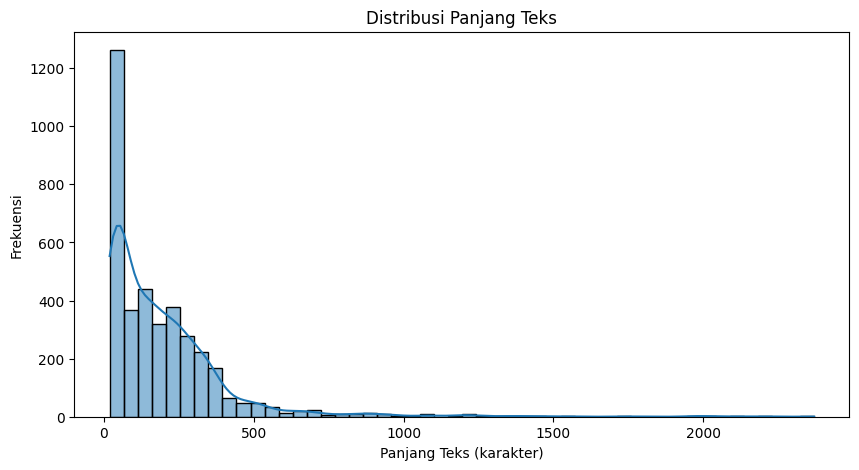

In [100]:
# 4. Visualisasi distribusi panjang teks
plt.figure(figsize=(10,5))
sns.histplot(datasetgabungan['text_length'], bins=50, kde=True)
plt.title('Distribusi Panjang Teks')
plt.xlabel('Panjang Teks (karakter)')
plt.ylabel('Frekuensi')
plt.show()

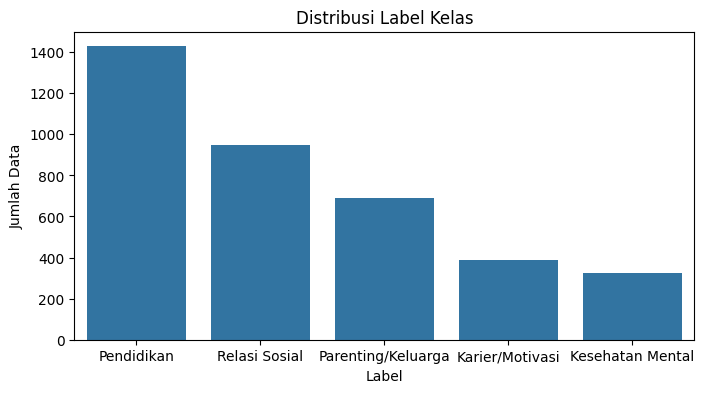

In [101]:
# 5. Distribusi kelas/label
plt.figure(figsize=(8,4))
sns.countplot(x='label', data=datasetgabungan, order=datasetgabungan['label'].value_counts().index)
plt.title('Distribusi Label Kelas')
plt.xlabel('Label')
plt.ylabel('Jumlah Data')
plt.show()

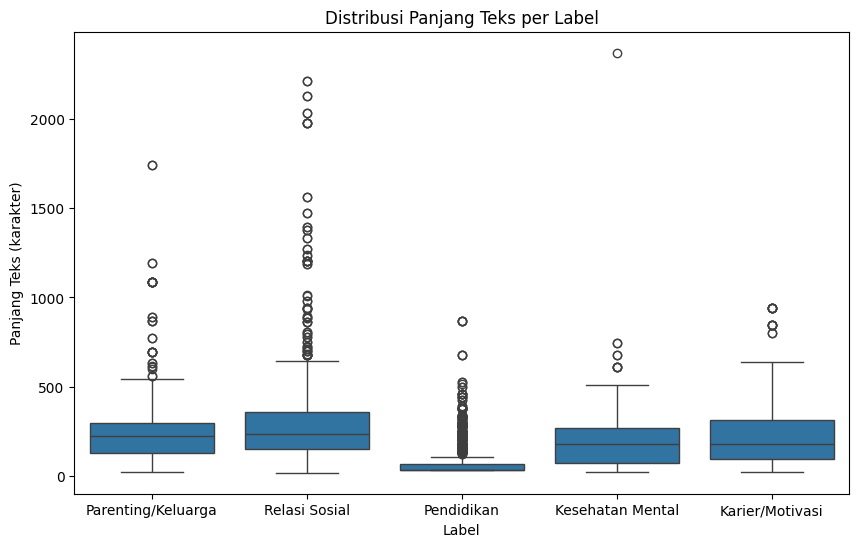

In [102]:
# 6. Boxplot panjang teks per label
plt.figure(figsize=(10,6))
sns.boxplot(x='label', y='text_length', data=datasetgabungan)
plt.title('Distribusi Panjang Teks per Label')
plt.xlabel('Label')
plt.ylabel('Panjang Teks (karakter)')
plt.show()

In [103]:
# 7. Contoh teks terpanjang dan terpendek per label
print("\nContoh teks terpanjang dan terpendek per label:")
for label in datasetgabungan['label'].unique():
    subset = datasetgabungan[datasetgabungan['label'] == label]
    longest = subset.loc[subset['text_length'].idxmax()]
    shortest = subset.loc[subset['text_length'].idxmin()]
    print(f"\nLabel: {label}")
    print(f" - Teks terpanjang ({longest['text_length']} karakter): {longest['text'][:200]}...")
    print(f" - Teks terpendek ({shortest['text_length']} karakter): {shortest['text'][:200]}...")


Contoh teks terpanjang dan terpendek per label:

Label: Parenting/Keluarga
 - Teks terpanjang (1744 karakter): seorang wanita dewasa muda kesulitan menemukan identitas sebenarnya ada rumah ini semua dimulai ketika punya pacar sekitar bulan lalu pacar berkencan selama beberapa bulan memutuskan melakukan tindaka...
 - Teks terpendek (22 karakter): terkadang kali semalam...

Label: Relasi Sosial
 - Teks terpanjang (2210 karakter): pacar telah bersama selama lima tahun sekarang sepanjang seluruh hari pertama kami bertemu dia memiliki kesempatan berinteraksi cukup banyak langsung memicu hubungan mendalam satu sama lain malam sama...
 - Teks terpendek (19 karakter): mengerti perhatikan...

Label: Pendidikan
 - Teks terpanjang (867 karakter): halo memiliki sepupu keluarga telah membuat merasa diremehkan aman frustrasi selama dia tinggal sini kota tahu dia berasal tempat cinta tetapi dia selalu menyatu pendek sangat temperamental jika ada s...
 - Teks terpendek (33 karakter): membuat pernikah

In [104]:
# 8. Frekuensi kata umum (optional, pakai CountVectorizer dari sklearn)
print("\nTop 10 kata paling sering muncul (semua data):")
vectorizer = CountVectorizer(stop_words='english', max_features=10)
X = vectorizer.fit_transform(datasetgabungan['text'])
freq = X.toarray().sum(axis=0)
freq_df = pd.DataFrame({'kata': vectorizer.get_feature_names_out(), 'frekuensi': freq})
print(freq_df.sort_values(by='frekuensi', ascending=False))


Top 10 kata paling sering muncul (semua data):
       kata  frekuensi
0       dia       3741
1       ini       1883
9    tetapi       1363
3  memiliki       1283
7      tahu       1184
4    merasa       1136
2      kami       1134
5     orang       1095
8     telah       1002
6   student       1000


## Ekstraksi Fitur (TF-IDF atau Count Vectorizer)

In [105]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = vectorizer.fit_transform(datasetgabungan['text'])

# Encode Label
le = LabelEncoder()
y = le.fit_transform(datasetgabungan['label'])

## Split Dataset Hasil Cleaning (DatasetFinal) 80:20

In [106]:
datasetfinal = datasetgabungan[datasetgabungan['text'].str.strip() != ""]

X = datasetfinal['text']
y = le.fit_transform(datasetfinal['label'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Simulasi Data Realistis ParentingMatch

Disimulasikan 500 responden yang menjawab 10 pertanyaan parenting (skala 1–5).
Setiap jawaban dijumlahkan menjadi skor total (sum).
Label ditentukan berdasarkan skor total:

- ≥ 40 → Authoritative
- 25 - 39 → Permissive
- < 25 → Authoritarian

Tujuan pembagian ini adalah mensimulasikan real-case kuisioner parenting style.
- Output: DataFrame dengan 10 kolom pertanyaan dan satu kolom label (Authoritative, dll).

In [107]:
# Buat data dummy 10 fitur
np.random.seed(42)
n_samples = 1000
data = []

for _ in range(n_samples):
    scores = np.random.randint(1, 6, size=10).tolist()  # skor 1–5

    # Ambil nilai total untuk tiap gaya
    group = {
        "Authoritative": sum(scores[:3]),
        "Permissive": sum(scores[3:6]),
        "Democratic": sum(scores[6:8]),
        "Neglectful": sum(scores[8:]),
    }

    max_val = max(group.values())
    top_styles = [k for k, v in group.items() if v == max_val]

    label = "Mixed" if len(top_styles) > 1 else top_styles[0]

    data.append(scores + [label])

# DataFrame
columns = [f"q{i+1}" for i in range(10)] + ["Label"]
df = pd.DataFrame(data, columns=columns)
df.head()

,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,Label
0,4,5,3,5,5,2,3,3,3,5,Mixed
1,4,3,5,2,4,2,4,5,1,4,Authoritative
2,2,5,4,1,1,3,3,2,4,4,Authoritative
3,3,4,4,1,3,5,3,5,1,2,Authoritative
4,4,1,4,2,2,1,2,5,2,4,Authoritative


# Encode label

##### Label (string) dikodekan ke dalam angka (0, 1, 2) dengan LabelEncoder agar bisa diproses oleh algoritma ML.
##### Dataset kemudian dibagi menjadi:

- 80%: Data latih (X_train, y_train)
- 20%: Data uji (X_test, y_test)

In [108]:
le = LabelEncoder()
df["Label_encoded"] = le.fit_transform(df["Label"])

X = df.drop(columns=["Label", "Label_encoded"])
y = df["Label_encoded"]

# Split dan latih model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeling dengan Random Forest

- Menggunakan Random Forest Classifier, cocok untuk klasifikasi multi-kelas dan robust terhadap overfitting.
- n_estimators=100: jumlah pohon dalam hutan acak.

In [109]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Evaluasi Model

##### Evaluasi dilakukan dengan:

- Classification Report (precision, recall, f1-score per kelas)
- Confusion Matrix untuk melihat prediksi vs kenyataan secara visual.

Hasil ini akan menunjukkan apakah model bisa mengenali gaya parenting dengan baik berdasarkan jawaban kuis.

               precision    recall  f1-score   support

Authoritative       0.78      0.96      0.86        73
   Democratic       0.67      0.25      0.36         8
        Mixed       0.42      0.27      0.33        30
   Neglectful       1.00      0.60      0.75        10
   Permissive       0.83      0.86      0.84        79

     accuracy                           0.77       200
    macro avg       0.74      0.59      0.63       200
 weighted avg       0.75      0.77      0.75       200



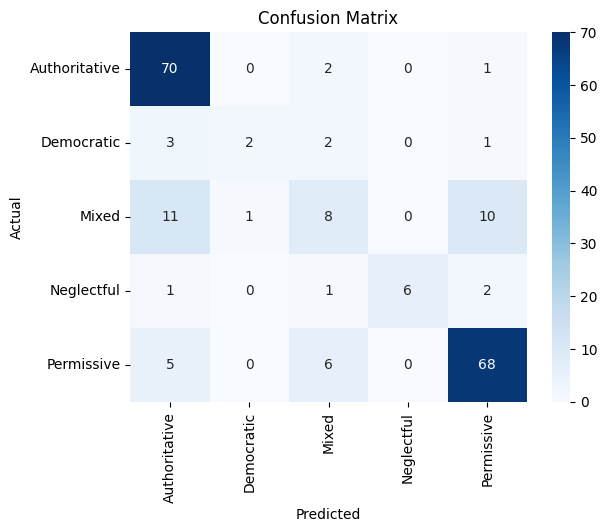

In [110]:
y_pred = model.predict(X_test)
present_labels = np.unique(y_test)
present_classes = le.inverse_transform(present_labels)

print(classification_report(y_test, y_pred, target_names=present_classes))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=present_classes, yticklabels=present_classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Simpan Model

- Model dan LabelEncoder disimpan dalam satu file .pkl.
- File ini nantinya bisa digunakan untuk integrasi ke backend (misal: PHP native atau Next.js API).

In [111]:
joblib.dump(le, "../ParentCare-BE/label_parenting_match_model.pkl")
joblib.dump(model, '../ParentCare-BE/parenting_match_model.pkl') 
print("Model disimpan sebagai parenting_match_model.pkl")

    

Model disimpan sebagai parenting_match_model.pkl
